In [56]:
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import KMeans
import pandas as pd  
from matplotlib import pyplot as plt

from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm
import seaborn as sns

import numpy as np

In [72]:
embedder = SentenceTransformer('all-MiniLM-L6-v2')

In [73]:
ds = pd.read_csv('https://raw.githubusercontent.com/LuisSante/Datasets/main/app_reviews.csv')

In [74]:
list_ = []  
for i in range(len(ds['package_name'].unique())):
    ds_aux = ds.loc[ds['package_name'] == ds['package_name'].unique()[i]]
    list_.append({'package_name':ds['package_name'].unique()[i], 'size': len(ds_aux)})

list_ = sorted(list_, key=lambda x: x['size'], reverse=True)
df = ds[ds['package_name'] == list_[8]['package_name']]
corpus = list(df['review'])

In [75]:
corpus_embeddings = embedder.encode(corpus, convert_to_tensor=True)
cosine_scores = util.cos_sim(corpus_embeddings, corpus_embeddings)

In [76]:
score = []
for k in range(1, 11):
    clustering_model = KMeans(n_clusters=k)
    clustering_model.fit(corpus_embeddings)
    score.append(clustering_model.inertia_)

In [77]:
best_kmeans = 0
best_score = 10000000
for i in range(len(score)):
    if(score[i] < best_score):
        best_score = score[i]
        best_kmeans = i+1
print("best score: ", best_score)
print("best k: ", best_kmeans)

best score:  1947.2804365300708
best k:  10


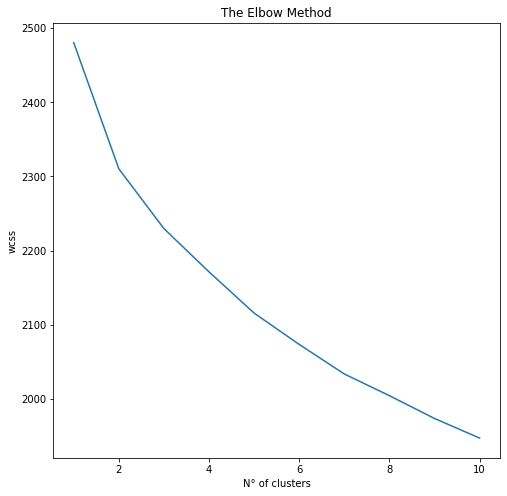

In [78]:
plt.figure(figsize=(8, 8))
plt.plot(range(1,11), score)
plt.title('The Elbow Method')
plt.xlabel('N° of clusters')
plt.ylabel('wcss')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.07573415
[0 1 1 ... 1 0 1]
 c :  [-5.25234493e-02  1.24323316e-02 -7.24293536e-03 -4.10007539e-03
  1.72383925e-03 -1.12156177e-02  4.61308226e-02  7.26558337e-03
 -1.43734800e-02 -5.50700869e-03  9.46740650e-03  1.98373939e-02
 -1.20653292e-03  1.94012460e-02 -1.23780584e-02  9.69824635e-03
  1.67109324e-02 -2.09274944e-02 -3.95772985e-02 -1.79942730e-02
 -6.18527892e-02 -1.99007562e-03  1.93547969e-02 -2.69208741e-03
 -2.47019408e-02 -2.23199071e-03 -3.05660942e-03  2.30083852e-02
  1.99193684e-02 -4.33764991e-02 -3.07323635e-02  3.19544485e-02
  1.91682530e-02  1.07019742e-03 -2.67833107e-02 -4.60090112e-03
 -1.73397066e-03 -7.60295760e-03  1.01383323e-03 -1.36968333e-03
 -1.29798424e-02 -3.74959420e-02  2.95512359e-03  3.01279179e-03
  1.28329318e-03  1.70945323e-02 -8.38507946e-04 -5.73196488e-03
  4.00272657e-02  4.32051454e-03 -1.12409714e-02 -3.44157348e-02
 -1.57252538e-02 -1.00710715e-02  1.75488008e-02  1.97838361e-02
 -

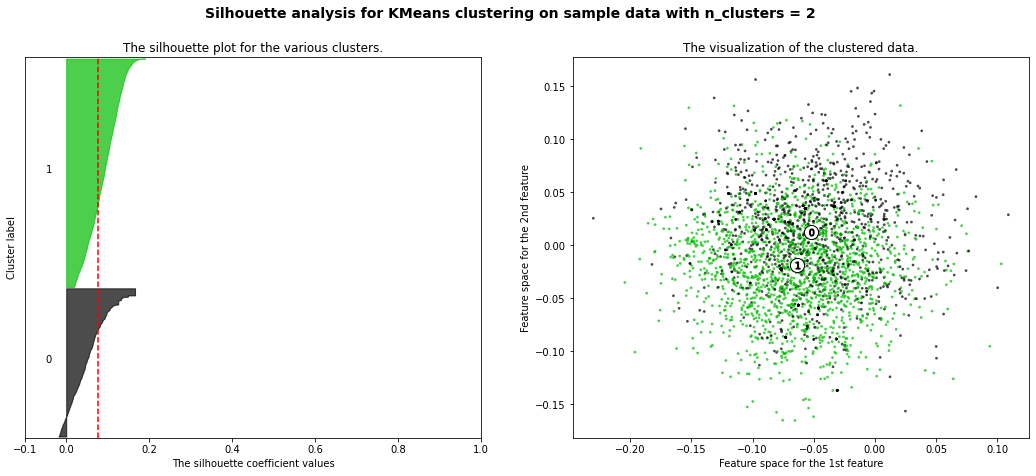

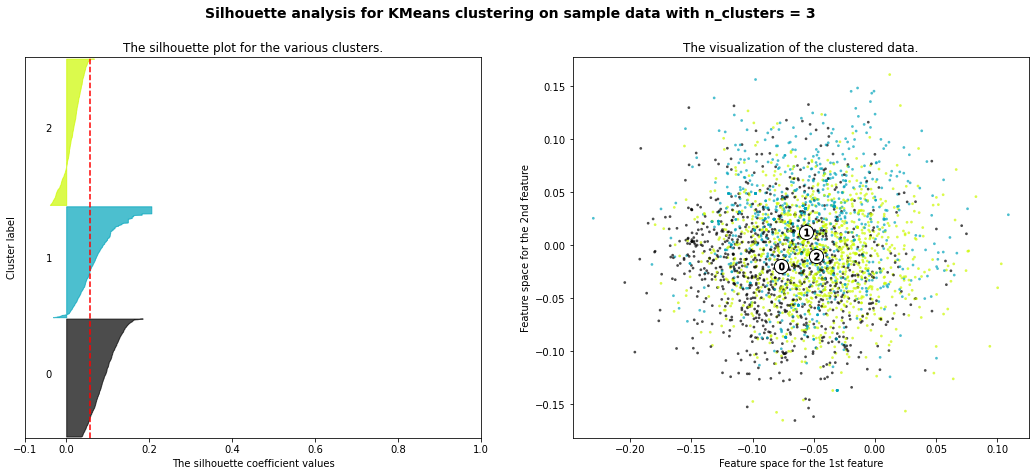

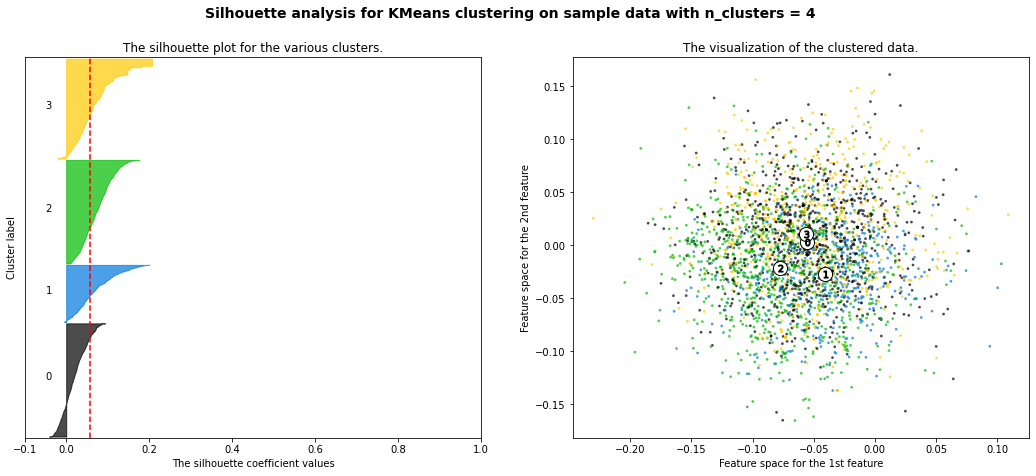

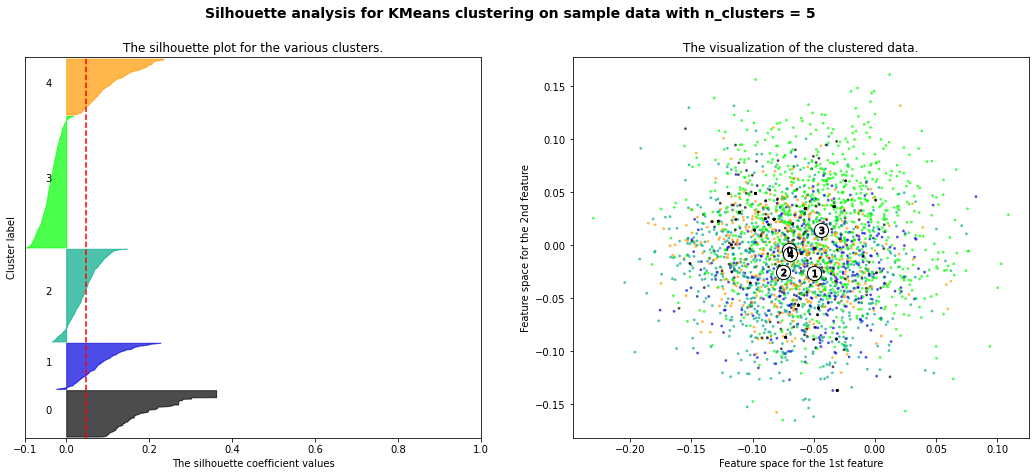

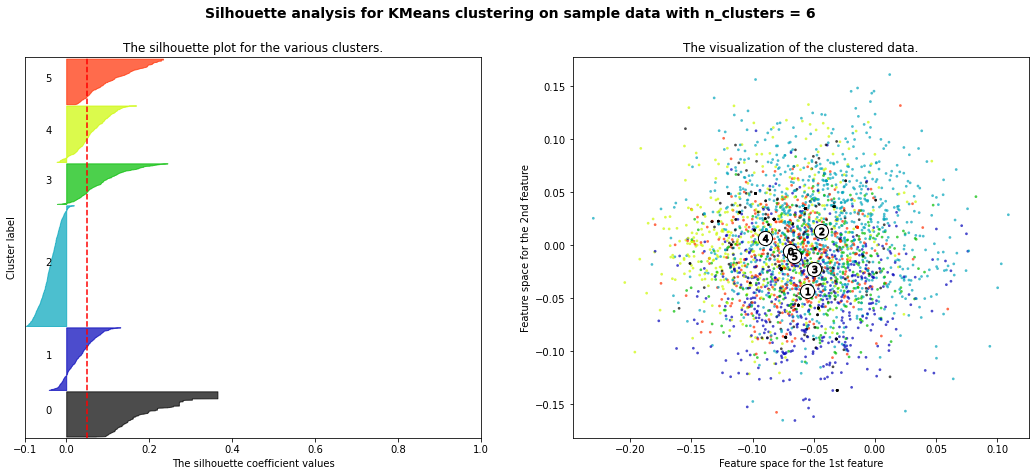

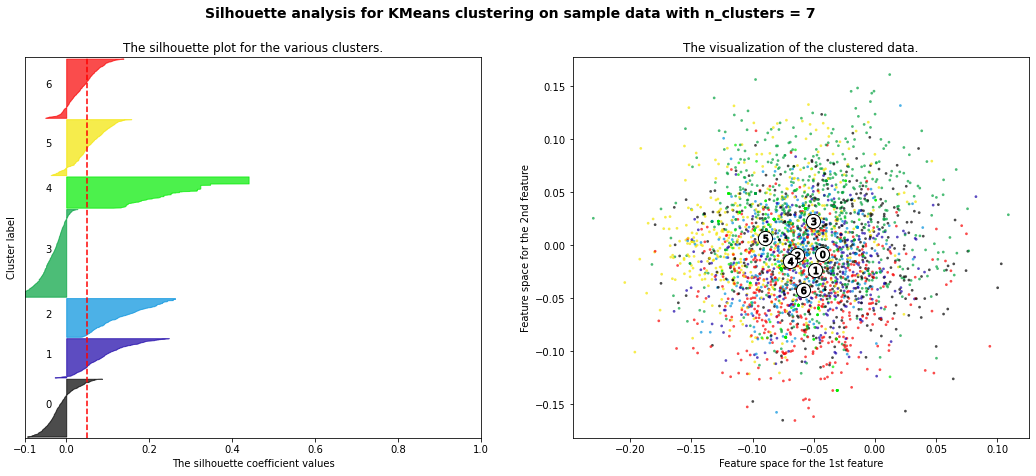

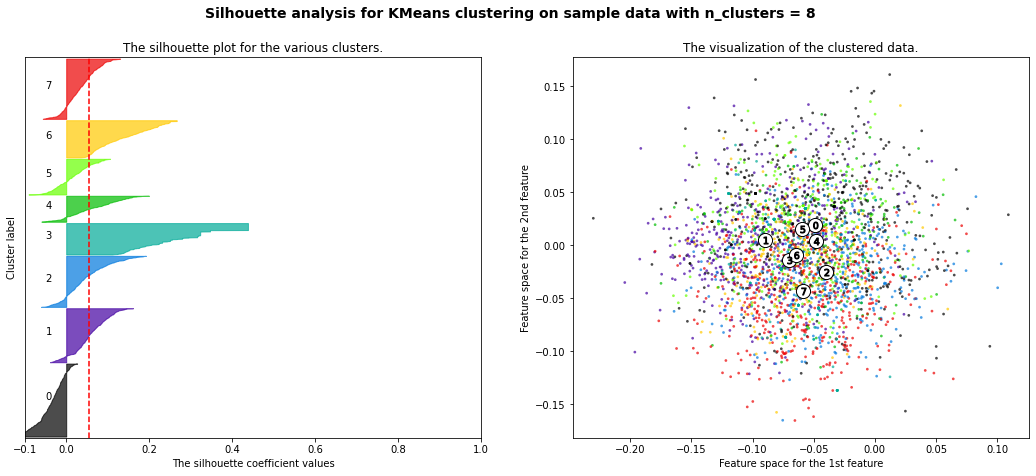

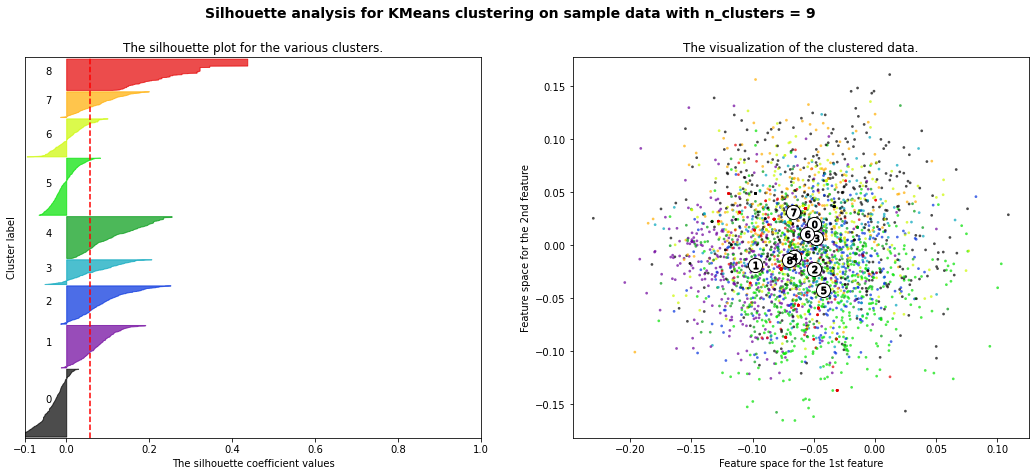

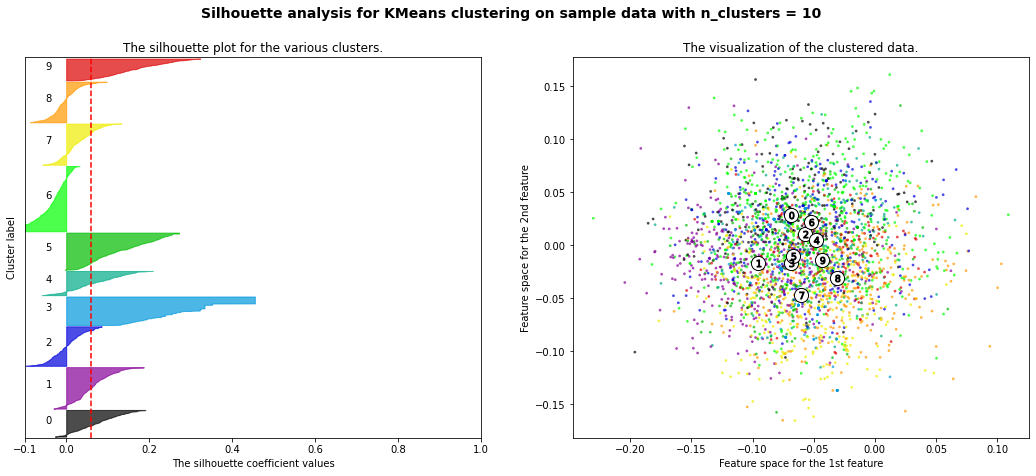

best avg:  0.04819756
best k:  5


In [79]:
average_best = 10000
best_k = 0
for k in range(2,11):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(corpus_embeddings) + (k + 1) * 10])

    clusterer = KMeans(n_clusters=k, init="k-means++", random_state=10)
    cluster_labels = clusterer.fit_predict(corpus_embeddings)

    silhouette_avg = silhouette_score(corpus_embeddings, cluster_labels)
    if(silhouette_avg < average_best): 
        average_best = silhouette_avg
        best_k = k
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg)

    print(cluster_labels)

    sample_silhouette_values = silhouette_samples(corpus_embeddings, cluster_labels)

    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10 

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(corpus_embeddings[:, 0], corpus_embeddings[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
        print(" c : ", c)        

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % k),
                 fontsize=14, fontweight='bold')

plt.show()
print("best avg: ", average_best)
print("best k: ", best_k)

In [94]:
corpus_2 = ['A man is eating food.',
          'A man is eating a piece of bread.',
          'A man is eating pasta.',
          'The girl is carrying a baby.',
          'The baby is carried by the woman',
          'A man is riding a horse.',
          'A man is riding a white horse on an enclosed ground.',
          'A monkey is playing drums.',
          'Someone in a gorilla costume is playing a set of drums.',
          'A cheetah is running behind its prey.',
          'A cheetah chases prey on across a field.'
          ]
corpus_embeddings_2 = embedder.encode(corpus_2)

# Perform kmean clustering
num_clusters = 5
clustering_model_2 = KMeans(n_clusters=num_clusters)
clustering_model_2.fit(corpus_embeddings_2)
cluster_assignment = clustering_model_2.labels_

clustered_sentences_2 = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences_2[cluster_id].append(corpus_2[sentence_id])
print(clustered_sentences_2)
center_2 = clustering_model_2.cluster_centers_
print("center : ",center_2)
print("centers[:, 0] : ", centers[:, 0])
print("centers[:, 1] : ", centers[:, 1])
print("sdasdasdasdad : ", centers[:1])

for i, cluster in enumerate(clustered_sentences_2):
    print("Cluster ", i+1)
    print(cluster)
    print("")

[['A man is eating food.', 'A man is eating a piece of bread.', 'A man is eating pasta.'], ['A cheetah is running behind its prey.', 'A cheetah chases prey on across a field.'], ['The girl is carrying a baby.', 'The baby is carried by the woman'], ['A man is riding a horse.', 'A man is riding a white horse on an enclosed ground.'], ['A monkey is playing drums.', 'Someone in a gorilla costume is playing a set of drums.']]
center :  [[ 0.02472616  0.00294538 -0.0130505  ...  0.04504786 -0.02498251
  -0.03937866]
 [ 0.03861746  0.07901674 -0.01882337 ...  0.01769911  0.03022731
   0.05294377]
 [-0.05627082 -0.02621724 -0.05728881 ... -0.03951702  0.11970837
  -0.00428921]
 [ 0.01618075  0.00425246  0.0453069  ...  0.00218675  0.05853743
  -0.00377093]
 [-0.00612485 -0.02084715  0.05041325 ...  0.04162261  0.0515007
   0.01486638]]
centers[:, 0] :  [-0.06892483 -0.09515762 -0.05747513 -0.06875579 -0.04783936 -0.06702694
 -0.05208753 -0.06043736 -0.0313314  -0.04355062]
centers[:, 1] :  [ 0